In [1]:
#Import Numpy, Tensorflow and Keras
import numpy as np
import tensorflow as tf
import math
import cv2

#from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use

from keras.layers import Input, LSTM, Dense, Lambda, GlobalAveragePooling1D, Add, Concatenate, Multiply
from keras.layers import Convolution2D, MaxPooling2D, Reshape, Flatten, BatchNormalization, Embedding
from keras import layers, backend ## IS THIS BEING USED?
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, Callback
import keras.backend as K
from keras import optimizers, metrics

from keras.utils import plot_model
from IPython.display import Image

from matplotlib import pyplot as plt

# Import our own helper functions
from prepare_data import get_decoder_data, get_decoder_data_int_sequences
import evaluation_model_keras as evalm


import helper_functions as hf


Using TensorFlow backend.


In [2]:
## This model takes a fixed image input size. This is contrast to our attention model that achieves a lot higher performance.


#Hyperparameters

hparams = {}

# Model
hparams['dsample_factor'] = 0.9
hparams['encoder_model'] = "CONVNET1" #"CONVNET1, CONVNET2
hparams['lstm_dim'] = 512


# Data
hparams['max_num_samples'] = 100000

# Training
hparams['epochs'] = 20
hparams['batch_size'] = 64

In [3]:
## This cell contains a bunch of functions for loading and preprocessing the data

def create_metric_output_files():

    file = open("/output/metrics.txt","w") 

    file.write("Train loss" + "\t" + "Val loss" + "\n")

    file.close()

def from_one_hot_to_latex_sequence(one_hot_sequence):
    tokens = []
    for idx, token_vector in enumerate(one_hot_sequence):

        sampled_token_index = np.argmax(token_vector)
        sampled_char = reverse_target_token_index[sampled_token_index]

        tokens.append(sampled_char)
        if sampled_char == '**end**':
            break
    
    return tokens

def shuffle_data(X,Y,Z,seed=None):
    if seed is not None:
        np.random.seed(seed)
    num_samples = X.shape[0]
    p = np.random.permutation(num_samples)
    if len(X.shape) == 3:
        X = X[p,:,:]
    elif len(X.shape) == 4:
        X = X[p,:,:,:]
    Y = Y[p]
    Z = Z[p]

    
    return X,Y,Z

def get_max_shape(images):

    max_height = 0
    max_width = 0

    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]

        if image.shape[1] > max_width:
            max_width = image.shape[1]


    return [max_height, max_width]


def normalize_images(images):

    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)

    return images

def down_sample(images, factor): 
    target_h = int(math.floor(float(images[0].shape[0]) * factor))
    target_w = int(math.floor(float(images[0].shape[1]) * factor))
    num_images = len(images)
    down_sampled_images = np.ones((num_images, target_h, target_w)) * 255

    for idx, image in enumerate(images):

        im = image

        #Downsample
        im = cv2.resize(im, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR


        down_sampled_images[idx, :, :] = im

    return down_sampled_images


def down_sample_flexible(images, factor): 
    print("downsampling images")
    new_images = []

    for image in images:
        new_image = cv2.resize(image, (0, 0), fx = factor, fy=factor, interpolation = cv2.INTER_AREA) #cv2.INTER_LINEAR
        new_images.append(new_image)

    return new_images


def pad_images(images, target_shape):
    

    if (target_shape == None):
        max_height, max_width = get_max_shape(images)
    else:
        max_height = target_shape[0]
        max_width = target_shape[1]

    target_shape = (max_height, max_width)
    print("target shape: ", target_shape)
    
    num_images = len(images)

    padded_images = np.ones((num_images, max_height, max_width)) * 255
    for idx, image in enumerate(images):

        h = image.shape[0]
        w = image.shape[1]

        padded_images[idx, :h, :w] = image

    
    return padded_images, target_shape

def get_vocabulary_size():
    return len(get_vocabulary())

def get_vocabulary(dataset):
    if dataset == "small":
        vocab = [line for line in open('data/tin/tiny_vocab.txt')]
    elif dataset == "test":
        vocab = [line for line in open('data/vocab.txt')]
    elif dataset == "train":
        vocab = [line for line in open('data/vocab.txt')]

    vocab = [x.strip('\n') for x in vocab]
    return vocab

def load_raw_data(dataset, max_token_length = 400, max_image_size = (60, 200), max_num_samples = 5000):
    
    token_vocabulary = []
    token_sequences = []
    images = []
    
    if dataset == "small":
        image_folder = 'data/tin/tiny/'
        formula_file_path = "data/tin/tiny.formulas.norm.txt"
    elif dataset == "test":
        image_folder = '../data/images_test/'
        formula_file_path = "../data/test.formulas.norm.txt"
    elif dataset == "train":
        image_folder = '../data/images_train/'
        formula_file_path = "../data/train.formulas.norm.txt"
    elif dataset == "val":
        image_folder = '../data/images_val/'
        formula_file_path = "../data/val.formulas.norm.txt"
        
    included_counter = 0
    examples_counter = 0
    with open (formula_file_path, "r") as myfile:

        for idx, token_sequence in enumerate(myfile):
            examples_counter += 1
            #Check token size:
            token_sequence = token_sequence.rstrip('\n')
            tokens = token_sequence.split()

            file_name = str(idx) + '.png'
            image = cv2.imread(image_folder + file_name, 0)
            
            if image is None:
                print("Not loading image with id:", idx)
                continue
            
            #print(tokens)
            if len(tokens) <= max_token_length and image.shape[0] <= max_image_size[0] and image.shape[1] <= max_image_size[1]:
                token_sequences.append('**start** ' + token_sequence + ' **end**')
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grey scale
                #print(image)
                
                images.append(image)
                for token in tokens:
                    if token not in token_vocabulary:
                        token_vocabulary.append(token)

                included_counter += 1
                if included_counter == max_num_samples:
                    break
    
    token_vocabulary.append("**start**")
    token_vocabulary.append("**end**")
    token_vocabulary.append("**other**")
    
    return images, token_sequences, token_vocabulary


def preprocess_images(images, target_shape):
    
    encoder_input = down_sample_flexible(images, hparams['dsample_factor'])
    encoder_input, target_shape = pad_images(encoder_input, target_shape)
    encoder_input = normalize_images(encoder_input)

    # Add dimension for TensorFlow Conv Layers to work properly as it needs (None, Height, Width, 1)
    encoder_input = encoder_input.reshape(encoder_input.shape[0], encoder_input.shape[1], encoder_input.shape[2], 1)

    return encoder_input, target_shape


def load_data(dataset, max_token_length, max_image_size, max_num_samples):
    
    ## First get all the training and validation data
    images_train, token_sequences_train, token_vocabulary_train = load_raw_data(dataset="train",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
    images_val, token_sequences_val, token_vocabulary_val = load_raw_data(dataset="val",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
    images_train_val = images_train + images_val
    token_sequences_train_val = token_sequences_train + token_sequences_val
    
    token_vocabulary = token_vocabulary_val + token_vocabulary_train
    token_vocabulary = list(set(token_vocabulary))
        
    images_train_val, target_shape = preprocess_images(images_train_val, target_shape=None)
    
    
    images_test, token_sequences_test, token_vocabulary_test = load_raw_data(dataset="test",  max_token_length = max_token_length, max_image_size = max_image_size, max_num_samples=max_num_samples)
    
    images_test, target_shape = preprocess_images(images_test, target_shape)
    
    return images_train_val, token_sequences_train_val, token_vocabulary, images_test, token_sequences_test

Text(0.5,1,u'Histogram: Sequence lengths')

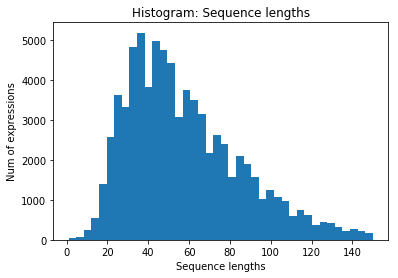

In [4]:
## Make a histogram of how long the sequences are
## Helps us decide on a cut off point

formula_file_path = "../data/train.formulas.norm.txt"

formula_lengths = []

with open (formula_file_path, "r") as myfile:
    for idx, token_sequence in enumerate(myfile):
        tokens = token_sequence.split()
        formula_lengths.append(len(tokens))

%matplotlib inline

plt.hist(formula_lengths, normed=False, bins=40)
plt.ylabel('Num of expressions');
plt.xlabel('Sequence lengths')
plt.title('Histogram: Sequence lengths')

In [5]:
## Load and process data (takes a up to 10 minutes)

max_token_length = 70
max_image_size = (60, 270)
max_num_samples = hparams['max_num_samples']
images_train_val, token_sequences_train_val, token_vocabulary, images_test, token_sequences_test = load_data(dataset="train", 
                                                               max_token_length=max_token_length,
                                                               max_image_size=max_image_size,
                                                               max_num_samples=max_num_samples)



## Note: Approx 15 images are missing and will not be loaded.

('Not loading image with id:', 2622)
('Not loading image with id:', 8140)
('Not loading image with id:', 14140)
('Not loading image with id:', 17337)
('Not loading image with id:', 23305)
('Not loading image with id:', 27738)
('Not loading image with id:', 29229)
('Not loading image with id:', 39602)
('Not loading image with id:', 42008)
('Not loading image with id:', 49252)
('Not loading image with id:', 49445)
('Not loading image with id:', 55767)
('Not loading image with id:', 63914)
('Not loading image with id:', 64058)
('Not loading image with id:', 64336)
('Not loading image with id:', 64600)
('Not loading image with id:', 66155)
('Not loading image with id:', 71501)
('Not loading image with id:', 3368)
downsampling images
('target shape: ', (45, 216))
('Not loading image with id:', 2931)
('Not loading image with id:', 5556)
downsampling images
('target shape: ', (45, 216))


In [6]:
print(len(token_sequences_train_val))
print(images_train_val.shape)
print(images_test.shape)

47156
(47156, 45, 216, 1)
(5136, 45, 216, 1)


In [7]:
# Let's check the data out:

num_decoder_tokens = len(token_vocabulary)

max_decoder_seq_length = max([len(txt.split()) for txt in token_sequences_train_val])

target_token_index = dict(
    [(token, i) for i, token in enumerate(token_vocabulary)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model

print("Maximum output sequence lenght: " + str(max_decoder_seq_length) + "\n")
print("Examples of sequences: ")
print("Ex. 1: " + str(token_sequences_train_val[0]) + "\n")
print("Ex. 1: " + str(token_sequences_train_val[1]) + "\n \n")

print("Number of examples: " + str(len(images_train_val)))


print("Number of tokens in our vocabulary: " + str(num_decoder_tokens))
print("5 example of tokens: " + str(token_vocabulary[0:5]) + "\n")

print("\n Example pairs (token, index) in dictionary: ")

for i, key in enumerate(target_token_index):
    print(key, target_token_index[key])
    if i > 10:
        break

_, image_h, image_w, _  = images_train_val.shape

Maximum output sequence lenght: 72

Examples of sequences: 
Ex. 1: **start** \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } } **end**

Ex. 1: **start** ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 , **end**
 

Number of examples: 47156
Number of tokens in our vocabulary: 484
5 example of tokens: ['\\perp', '\\leq', '\\begin{picture}', '\\supset', '\\protectm']


 Example pairs (token, index) in dictionary: 
('V', 75)
('\\perp', 0)
('\\leq', 1)
('\\setminus', 27)
('\\supset', 3)
('/', 414)
('\\raisebox', 5)
('0', 6)
('\\left\\Vert', 7)
('\\Re', 8)
('\\smallint', 9)
('\\vspace', 73)


In [8]:
# For forced teaching, we need decoder_input data and decoder target data. (takes a few minutes)
# Decoder target data is just decoder_input_data offset by one time step.

decoder_input_data, decoder_target_data = get_decoder_data(token_sequences_train_val,
                                                            token_vocabulary,
                                                           num_decoder_tokens,
                                                           max_decoder_seq_length,
                                                           target_token_index)

print("Each row is a one-hot encoded token in the sequence.")
print("We have 10 columns because there are 10 tokens in our vocabulary")
print("We have 9 rows, because maximum output length is 9")
print("")

print("Decoder INPUT sequence example 1")
print(decoder_input_data[0]) #Each row is a one-hot encoded token in the sequence.
print("")
print("Decoder TARGET sequence example 1 (the same as above offset by one time step)")
print(decoder_target_data[0]) #Each row is a one-hot encoded token in the sequence.

('Number of tokens not in the vocab: ', 0)
Each row is a one-hot encoded token in the sequence.
We have 10 columns because there are 10 tokens in our vocabulary
We have 9 rows, because maximum output length is 9

Decoder INPUT sequence example 1
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

Decoder TARGET sequence example 1 (the same as above offset by one time step)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [9]:
## Shuffle our data


images_train_val, decoder_input_data, decoder_target_data = shuffle_data(images_train_val, decoder_input_data, decoder_target_data, 100)

In [10]:
_, test_target_data = get_decoder_data(token_sequences_test,
                                                            token_vocabulary,
                                                           num_decoder_tokens,
                                                           max_decoder_seq_length,
                                                           target_token_index)

('Number of tokens not in the vocab: ', 13)


Latex: 
['{', '\\cal', 'L', '}', '_', '{', '\\theta', '}', '=', '\\frac', '{', '\\theta', '}', '{', '3', '2', '{', '\\pi', '}', '^', '{', '2', '}', '}', '\\epsilon', '^', '{', '\\mu', '\\nu', '\\lambda', '\\sigma', '}', 'F', '_', '{', '\\mu', '\\nu', '}', '^', '{', 'a', '}', 'F', '_', '{', '\\lambda', '\\sigma', '}', '^', '{', 'a', '}', ',', '**end**']


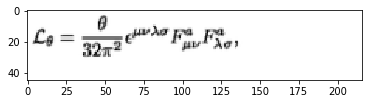

Latex: 
['S', '\\left(', 'x', ',', 'y', ',', 'A', '\\right)', '=', '\\left(', 'i', '\\beta', '_', '{', '\\mu', '}', 'D', '^', '{', '\\mu', '}', '-', 'm', '\\right)', '^', '{', '-', '1', '}', '\\delta', '^', '{', '4', '}', '\\left(', 'x', '-', 'y', '\\right)', '**end**']


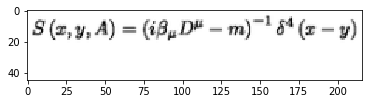

Latex: 
['\\int', 'D', '\\varphi', 'e', '^', '{', 'S', '[', '\\varphi', ']', '}', '\\approx', 'e', '^', '{', 'S', '[', '\\varphi', '_', '{', '0', '}', ']', '}', '**end**']


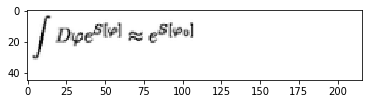

In [11]:
## Look at a few examples (we have downsampled them further from what is in the data folder):
## Note that we have added the "**start**" and "**end**" token to all sentences.



for i in range(3,6):

    print("Latex: ")
    print(from_one_hot_to_latex_sequence(decoder_target_data[i]))

    plt.imshow(images_train_val[i,:,:,0], cmap='gray')
    plt.show()



In [12]:
## Time to build our model: Image -> ConvNet Encoder -> LSTM Decoder --> Latex


## Encoder step I: Encoding image into vectors (e1, e2, ..., en)
## Convnet design from Guillaume Genthial https://github.com/guillaumegenthial/im2latex/blob/master/model/encoder.py

def get_encoded1(image_h, image_w):

    encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image", dtype='float32')

    
    # Conv + max_pool / 2
    encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)
    encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    encoded = BatchNormalization()(encoded)
    # Conv + max_pool /2
    encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    encoded = BatchNormalization()(encoded)
    
    # 2 Conv
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    
    # Pooling + Convnet + Pooling (Note pool_size)
    encoded = MaxPooling2D(pool_size=(2,1))(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = MaxPooling2D(pool_size=(1,2))(encoded)
    
    # BatchNormalization, Convolution
    encoded = BatchNormalization()(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

    #encoded = time_signal()(encoded)

    encoded_shape = encoded.get_shape().as_list()
    _, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
    encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
    
    return encoder_inputs, encoded


def get_encoded2(image_h, image_w):

    encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image", dtype='float32')

    
    # Conv
    encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)

    encoded = BatchNormalization()(encoded)
    # Conv
    encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)

    encoded = BatchNormalization()(encoded)
    
    # 2 Conv
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    
    # Pooling + Convnet + Pooling (Note pool_size)
    encoded = MaxPooling2D(pool_size=(2,1))(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = MaxPooling2D(pool_size=(1,2))(encoded)
    
    # BatchNormalization, Convolution
    encoded = BatchNormalization()(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

    #encoded = time_signal()(encoded)

    encoded_shape = encoded.get_shape().as_list()
    _, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
    encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
    
    return encoder_inputs, encoded

## Taken from paper: http://cs231n.stanford.edu/reports/2017/pdfs/815.pdf
def get_encoded3(image_h, image_w):

    encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image", dtype='float32')

    
    # Conv
    encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)

    encoded = BatchNormalization()(encoded)
    # Conv
    encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)

    encoded = BatchNormalization()(encoded)
    
    # 2 Conv
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    
    # 
    encoded = Convolution2D(filters=512, kernel_size=(4,2), strides=(2,2), activation='relu')(encoded)
    
    # BatchNormalization, Convolution
    encoded = BatchNormalization()(encoded)
    encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

    #encoded = time_signal()(encoded)

    encoded_shape = encoded.get_shape().as_list()
    _, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
    encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
    
    return encoder_inputs, encoded

In [13]:
## Encoder step II: transforming (e1, e2... en) to h0 and c0 
# h0, and c0  will be the initial state of the decoder

# Call convolutional encoder
if hparams['encoder_model'] == "CONVNET1":
    encoder_inputs, encoded = get_encoded1(image_h, image_w)
elif hparams['encoder_model'] == "CONVNET2":
    encoder_inputs, encoded = get_encoded2(image_h, image_w)
elif hparams['encoder_model'] == "CONVNET3":
    encoder_inputs, encoded = get_encoded3(image_h, image_w)
    
encoded_shape = encoded.get_shape().as_list()

#Compute the average e from encoding.

e_average = GlobalAveragePooling1D(name='average_e')(encoded)

e_average = BatchNormalization()(e_average)


#Compute h0 and c0, from e_average, following Genthial's suggestion
h0 = Dense(hparams['lstm_dim'], activation='tanh', name="h0")(e_average)
c0 = Dense(hparams['lstm_dim'], activation='tanh', name="c0")(e_average)

h0 = BatchNormalization()(h0)
c0 = BatchNormalization()(c0)


### Decoder. LSTM + Softmax layer

In [14]:

# Set up the decoder, using `encoder_states` as initial state.
#decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='decoder_input_sequence')


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='decoder_input_sequence')

decoder_lstm = LSTM(hparams['lstm_dim'], return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=[h0, c0])

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [19]:
## Putting the training model together

model = Model(inputs=[encoder_inputs, decoder_inputs],outputs=decoder_outputs)

## Visualize the training model

#plot_model(model, to_file='model_visualizations/training_model.png', show_shapes=False)

#Image(filename='model_visualizations/training_model.png') 

In [20]:
# Callback to get losses for each batch (and not each epoch)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    def on_epoch_end(self, epoch, logs={}):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        file = open("/output/" + "metrics.txt","a") 
        
        file.write(str(train_loss) + "\t" + str(val_loss) + "\n")

        file.close()
        
loss_history = LossHistory()

### Optimizer

In [21]:


learning_rate = 0.003 # OBS: Learning rate is set with a callback instead (see next cell)
beta_1 = 0.9 # Keras default
beta_2 = 0.999 # Keras default
epsilon=1e-08 # Keras default
decay=0.0004 # 
clipvalue = 5 # 

adam_optimizer = optimizers.Adam(lr=learning_rate,
                                       beta_1=beta_1,
                                       beta_2=beta_2, 
                                       epsilon=epsilon,
                                       decay=decay,
                                        clipvalue=clipvalue)


In [ ]:
## Compile and train the model

# checkpoint
filepath="checkpoints/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, period=2)

callbacks_list = [loss_history]

model.compile(adam_optimizer, loss='categorical_crossentropy')

batch_size = hparams['batch_size']

model_history = model.fit([images_train_val, decoder_input_data],
          decoder_target_data,
          batch_size=batch_size,
          epochs=hparams['epochs'],
          validation_split=0.1,
         callbacks=callbacks_list)


In [ ]:
hf.visualize_training_history(model_history)

In [ ]:
plt.plot(loss_history.losses)

In [ ]:
## Save the model

#print("Saving model")
model.save_weights('/output/my_model_weights.h5')
#model.load_weights('my_model_weights.h5')

In [ ]:
## NOTE:

### Uncomment to use pretrained weights (though only for 5 epochs, 
## so not nearly enough to make meaningful predictions for this large dataset)

# model.load_weights("checkpoints/weights.best.hdf5")

         
         

In [ ]:
# Save the model and show summary

#model.save('s2s.h5')

print("Encoder / decoder model training: ")
model.summary()

### Inference

In [ ]:
### Time for inference


# Step 1. Set up the encoder as a separate model:

encoder_model = Model(encoder_inputs, [h0, c0]) #encoded and e_average are included for debugging purposes
encoder_model.save("/output/encoder.h5")

In [ ]:
# Step 2. Set up the decoder as a separate model.

# The decoder takes three inputs: the input_state_h, input_state_c and a vector (last prediction)

decoder_state_input_h = Input(shape=(hparams['lstm_dim'],), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(hparams['lstm_dim'],), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Will be a one-hot encoded vector
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
decoder_model.save("/output/decoder.h5")



In [ ]:
## Plot the inference Encoder Model 
#plot_model(encoder_model, to_file='model_visualizations/inference_encoder_model.png', show_shapes=True) 
#Image(filename='inference_encoder_model.png') 



In [ ]:
## Plot the inference Decoder model
#plot_model(decoder_model, to_file='model_visualizations/inference_decoder_model.png', show_shapes=True)
#Image(filename='inference_decoder_model.png') 


In [ ]:
## Decode sequence using our two models

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    h0_ = states_value[0]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["**start**"]] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    
    decoded_sentence_list = []
    decoded_sentence = ''
    while not stop_condition:
        #print(target_seq)
        output_tokens, h, c = decoder_model.predict(
        [target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_prob = np.max(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        
        # Exit condition: either hit max length
        # or find stop token.
        if (sampled_char == '**end**' or
            len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True
        else: 
            decoded_sentence = decoded_sentence + ' ' + sampled_char
            decoded_sentence_list.append(sampled_char)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    #Return h0_ for debugging
    return decoded_sentence, decoded_sentence_list, h0_


In [ ]:
def filter_data(images, seq_target_data, max_token_length = 100):
    
    filtered_images = []
    filtered_target_data = []
    
    for idx, sentence in enumerate(evaluation_target_data):
        if len(sentence) <= max_token_length:
            filtered_images.append(images[idx])
            filtered_target_data.append(sentence)

    return filtered_images, filtered_target_data

In [ ]:

def predict(images):

    #images_test, token_sequences_test
    num_test = images.shape[0] #

    predictions = []

    print("Predicting " + str(num_test) + " images")
    
    for seq_index in range(num_test):

        input_seq = evaluation_images[seq_index: seq_index + 1]

        decoded_sentence, decoded_sentence_list, h0_ = decode_sequence(input_seq)

        predictions.append(decoded_sentence_list)

        if seq_index % 200 == 0:
            print("Finished " + str(seq_index))
        
    return predictions

In [ ]:
evaluation_set = "VAL"
# 4716
if evaluation_set == "TEST":
    evaluation_images = images_test
    evaluation_target_data = test_target_data
elif evaluation_set == "VAL":
    evaluation_images = images_train_val[-4716:,:,:,:]
    evaluation_images = np.reshape(evaluation_images, (evaluation_images.shape[0], evaluation_images.shape[1], evaluation_images.shape[2], 1))
    evaluation_target_data = decoder_target_data[-4716:]
elif evaluation_set == "TRAIN":
    evaluation_images = images_train_val[:3000,:,:,:]
    evaluation_images = np.reshape(evaluation_images, (evaluation_images.shape[0], evaluation_images.shape[1], evaluation_images.shape[2], 1))
    evaluation_target_data = decoder_target_data[:3000]    

# Filter data and only look at images with shorter sequences

#evaluation_images, evaluation_target_data = filter_data(evaluation_images, evaluation_target_data, max_token_length = 40)

eval_ground_truth = []

for test_sequence in evaluation_target_data:
    ground_truth = from_one_hot_to_latex_sequence(test_sequence)
    eval_ground_truth.append(ground_truth)

In [ ]:
predictions = predict(evaluation_images)

In [ ]:
## Code for exact match and token accuracy was adapted from NMT Tutorial https://github.com/tensorflow/nmt

import distance

# CHECK
def exact_match(labels, predictions, max_token_check=None):
    #"""Compute exact match"""
    match = 0.0
    count = 0.0
    if max_token_check == None:
        max_token_check = 1000
    for idx in range(len(labels)):
        if np.all(labels[idx][:max_token_check] == predictions[idx][:max_token_check]):
            match += 1

        count += 1
    return 100 * match / count


def token_accuracy(labels, predictions, max_token_check=None):
    #"""Compute accuracy on per word basis."""
    total_acc, total_count = 0., 0.
    if max_token_check==None:
        m_length = 1000
    else:
        m_length = max_token_check

    for idx, target_sentence in enumerate(labels):
        prediction = predictions[idx]

        match = 0.0

        total_count += 1 
        for pos in range(min(len(target_sentence), len(prediction), m_length)):
            label = target_sentence[pos]
            pred = prediction[pos]
            if label == pred:
                match += 1
        
             
        if max_token_check==None:
            total_acc += 100 * match / max(len(target_sentence), len(prediction))
        else:
            total_acc += 100 * match / min(len(target_sentence), len(prediction), m_length)
            
    return total_acc / total_count







def lev_dist(labels, predictions, max_token_check=None):
    
    avg_distance = 0
    count = 0.0
  

    for idx in range(len(labels)):


        if max_token_check is not None:
            lev_distance = distance.levenshtein(labels[idx][:max_token_check], predictions[idx][:max_token_check])
        else:
            lev_distance = distance.levenshtein(labels[idx], predictions[idx])
            lev_distance = lev_distance / len(labels[idx])

        avg_distance = avg_distance + lev_distance
        count += 1



    avg_distance = float(avg_distance) / count
    return avg_distance



def get_metrics(labels, predictions, max_token_check=None):
    exact_match_avg = exact_match(labels, predictions, max_token_check)
    token_accuracy_avg = token_accuracy(labels, predictions, max_token_check)
    edit_distance_avg = lev_dist(labels, predictions, max_token_check)
    return exact_match_avg, token_accuracy_avg, edit_distance_avg


In [ ]:
metrics1 = get_metrics(eval_ground_truth, predictions)

In [ ]:
print(metrics1)
print(metrics2)
print(metrics3)
print(metrics4)

In [ ]:
## Show some predictions with ground truth

n = 20


for i in range(n):
    
    plt.imshow(np.squeeze(evaluation_images[i]), cmap='gray')
    plt.show()
    
    print("Ground truth")
    print(*eval_ground_truth[i])
    
    print("Prediction")
    print(*predictions[i])